# LendingClub Risk Analysis Project

## Problem
For this project we will be exploring publicly available data from [LendingClub.com](https://www.lendingclub.com/). Lending Club connects people who need money (borrowers) with people who have money (investors). Hopefully, as an investor you would want to invest in people who showed a profile of having a high probability of paying you back. We will try to create a model that will help predict this.

Lending club had a [very interesting year in 2016](https://en.wikipedia.org/wiki/Lending_Club#2016), so let's check out some of their data and keep the context in mind. This data is from before they even went public.

We will use lending data from 2007-2010 and be trying to classify and predict whether or not the borrower paid back their loan in full.

Here are what the columns represent:
* credit.policy: 1 if the customer meets the credit underwriting criteria of LendingClub.com, and 0 otherwise.
* purpose: The purpose of the loan (takes values "credit_card", "debt_consolidation", "educational", "major_purchase", "small_business", and "all_other").
* int.rate: The interest rate of the loan, as a proportion (a rate of 11% would be stored as 0.11). Borrowers judged by LendingClub.com to be more risky are assigned higher interest rates.
* installment: The monthly installments owed by the borrower if the loan is funded.
* log.annual.inc: The natural log of the self-reported annual income of the borrower.
* dti: The debt-to-income ratio of the borrower (amount of debt divided by annual income).
* fico: The FICO credit score of the borrower.
* days.with.cr.line: The number of days the borrower has had a credit line.
* revol.bal: The borrower's revolving balance (amount unpaid at the end of the credit card billing cycle).
* revol.util: The borrower's revolving line utilization rate (the amount of the credit line used relative to total credit available).
* inq.last.6mths: The borrower's number of inquiries by creditors in the last 6 months.
* delinq.2yrs: The number of times the borrower had been 30+ days past due on a payment in the past 2 years.
* pub.rec: The borrower's number of derogatory public records (bankruptcy filings, tax liens, or judgments).

## Understanding the Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report


# to allow the output of plotting commands to be displayed inline
%matplotlib inline
# turn off jedi to allow for faster tab autocomplete usage
%config Completer.use_jedi = False

# set global styling
sns.set_style('whitegrid')
sns.set_palette('YlGnBu_r',3)

loans = pd.read_csv('loan_data.csv')

loans.head()

,credit.policy,purpose,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
0,1,debt_consolidation,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,0,0,0
1,1,credit_card,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,0,0,0
2,1,debt_consolidation,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,0,0,0
3,1,debt_consolidation,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,0,0,0
4,1,credit_card,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,1,0,0


In [2]:
loans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9578 entries, 0 to 9577
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   credit.policy      9578 non-null   int64  
 1   purpose            9578 non-null   object 
 2   int.rate           9578 non-null   float64
 3   installment        9578 non-null   float64
 4   log.annual.inc     9578 non-null   float64
 5   dti                9578 non-null   float64
 6   fico               9578 non-null   int64  
 7   days.with.cr.line  9578 non-null   float64
 8   revol.bal          9578 non-null   int64  
 9   revol.util         9578 non-null   float64
 10  inq.last.6mths     9578 non-null   int64  
 11  delinq.2yrs        9578 non-null   int64  
 12  pub.rec            9578 non-null   int64  
 13  not.fully.paid     9578 non-null   int64  
dtypes: float64(6), int64(7), object(1)
memory usage: 1.0+ MB


There are 9,577 rows of data with no missing values. There are 14 columns and I will try to predict not.fully.paid given the other features.

In [3]:
loans.describe()

,credit.policy,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
count,9578.000000,9578.000000,9578.000000,9578.000000,9578.000000,9578.000000,9578.000000,9.578000e+03,9578.000000,9578.000000,9578.000000,9578.000000,9578.000000
mean,0.804970,0.122640,319.089413,10.932117,12.606679,710.846314,4560.767197,1.691396e+04,46.799236,1.577469,0.163708,0.062122,0.160054
std,0.396245,0.026847,207.071301,0.614813,6.883970,37.970537,2496.930377,3.375619e+04,29.014417,2.200245,0.546215,0.262126,0.366676
min,0.000000,0.060000,15.670000,7.547502,0.000000,612.000000,178.958333,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.103900,163.770000,10.558414,7.212500,682.000000,2820.000000,3.187000e+03,22.600000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.122100,268.950000,10.928884,12.665000,707.000000,4139.958333,8.596000e+03,46.300000,1.000000,0.000000,0.000000,0.000000
75%,1.000000,0.140700,432.762500,11.291293,17.950000,737.000000,5730.000000,1.824950e+04,70.900000,2.000000,0.000000,0.000000,0.000000
max,1.000000,0.216400,940.140000,14.528354,29.960000,827.000000,17639.958330,1.207359e+06,119.000000,33.000000,13.000000,5.000000,1.000000


## Exploratory Data Analysis

Text(0.5, 1.0, 'Distribution of FICO Score by Credit.Policy')

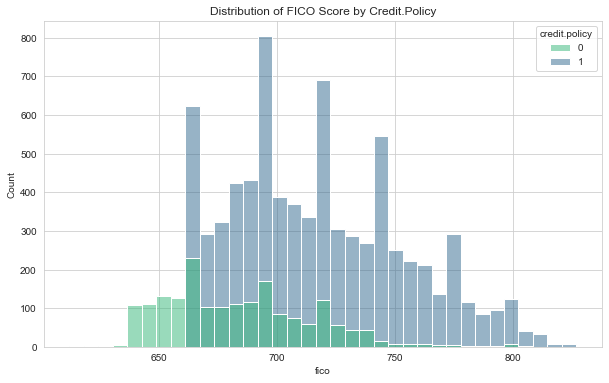

In [4]:
# increase figure size
plt.figure(figsize=(10,6))
sns.histplot(data=loans, x='fico', hue='credit.policy', bins=35, palette='viridis_r')
plt.title('Distribution of FICO Score by Credit.Policy')

There are much more people that meet the credit underwriting criteria of LendingClub (credit.policy = 1). The lower the borrower's FICO credit score, the less likely they are to meet LendingClub's criteria. This intuitively makes sense as LendingClub would likely use credit score as a factor in their criteria. Following that, there is also a sharp cutoff point where if the borrower has a FICO score of less than ~660, they do not meet the criteria.

Text(0.5, 1.0, 'Distribution of FICO Score by Not.Fully.Paid')

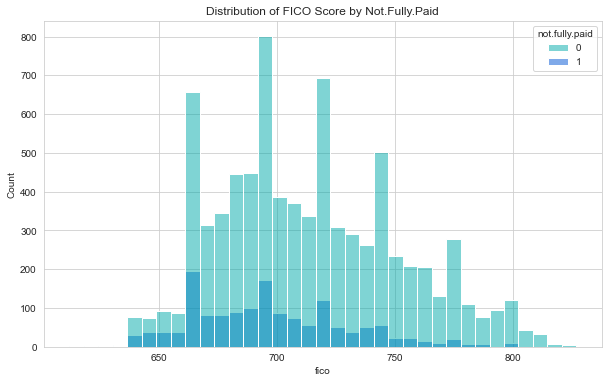

In [5]:
# increase figure size
plt.figure(figsize=(10,6))
sns.histplot(data=loans, x='fico', hue='not.fully.paid', bins=35, palette='winter_r')
plt.title('Distribution of FICO Score by Not.Fully.Paid')
# majority is 0, similar distribution between 0 and 1

The majority of borrowers are fully paid (not.fully.paid = 0). There is a similar distribution of FICO scores for full paid vs. not fully paid.

Text(0.5, 1.0, 'Count by Purpose')

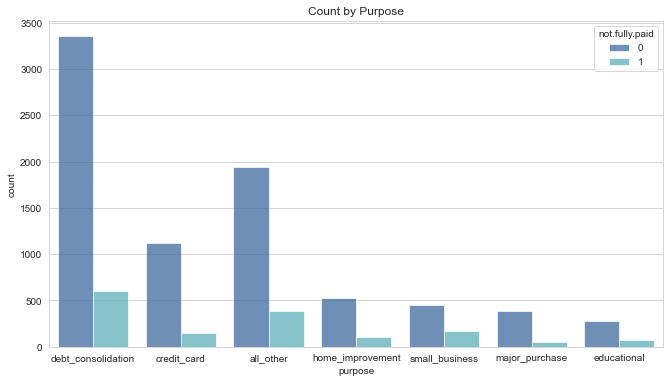

In [6]:
# increase figure size
plt.figure(figsize=(11,6))
sns.countplot(data=loans, x='purpose', hue='not.fully.paid', alpha=0.7)
plt.title('Count by Purpose')

Text(0.5, 1.03, 'Interest Rate vs FICO')

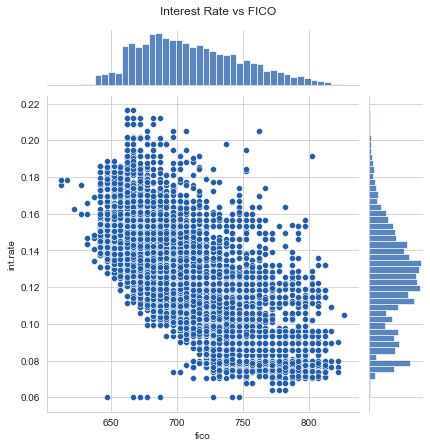

In [7]:
sns.jointplot(data=loans, x='fico', y='int.rate')
plt.suptitle('Interest Rate vs FICO', y=1.03)

The lower the FICO score, the higher the interest rate vs. the higher the FICO score, the higher the interest rate. This makes sense as FICO is used as a measurement of your risk. Higher risk = higher rate.    

In the next plot, we can check to see if this trend differs between not.fully.paid and credit.policy.

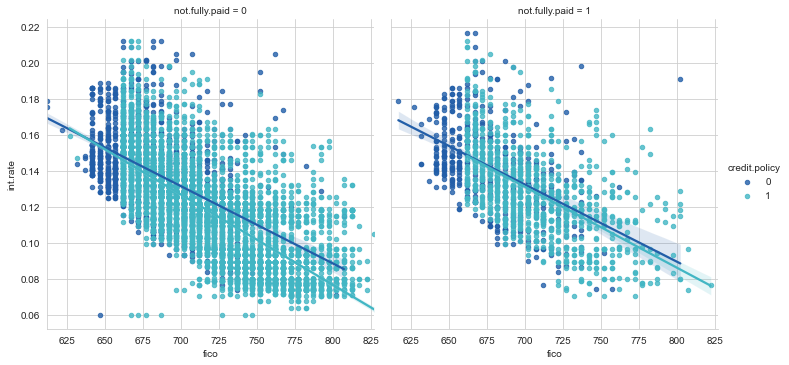

In [8]:
sns.lmplot(data=loans, x='fico', y='int.rate', hue='credit.policy', 
           col='not.fully.paid', scatter_kws={"s": 20})

The line of best fit for borrowers meeting LendingClub's credit policy criteria where the loans are fully paid is slighter steeper vs not meeting it. If your loans are fully paid, you'll have an even lower interest rate given you have a high FICO score.

## Data Cleaning

In [9]:
# list of categorical features to be transformed to dummy variables
cat_feats = ['purpose']
# combined data including dummy variables for categorical features
final_data = pd.get_dummies(loans, columns=cat_feats, drop_first=True)
final_data.head()

,credit.policy,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_major_purchase,purpose_small_business
0,1,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,0,0,0,0,1,0,0,0,0
1,1,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,0,0,0,1,0,0,0,0,0
2,1,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,0,0,0,0,1,0,0,0,0
3,1,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,0,0,0,0,1,0,0,0,0
4,1,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,1,0,0,1,0,0,0,0,0


## Model Training

In [10]:
# define features vs category we're predicting
X = final_data.drop('not.fully.paid', axis=1)
y = final_data['not.fully.paid']

# perform train test split with test size 30%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

# instantiate the decision tree object
dtree = DecisionTreeClassifier()

# fit decision tree model to the train data
dtree.fit(X_train, y_train)

# predicting not.fully.paid based on test features
dtree_pred = dtree.predict(X_test)

# evaluate this model in order to compare with our random forest model
print(confusion_matrix(y_test, dtree_pred))
print(classification_report(y_test, dtree_pred))

[[2002  429]
 [ 344   99]]
              precision    recall  f1-score   support

           0       0.85      0.82      0.84      2431
           1       0.19      0.22      0.20       443

    accuracy                           0.73      2874
   macro avg       0.52      0.52      0.52      2874
weighted avg       0.75      0.73      0.74      2874



In [11]:
# instantiate the random forest model with # trees = 600
rfc = RandomForestClassifier(n_estimators=600)
# fit random forest model with train data
rfc.fit(X_train, y_train)

RandomForestClassifier(n_estimators=600)

## Model Testing

In [12]:
# predicting not.fully.paid using test features
predictions = rfc.predict(X_test)

## Model Evaluation

In [13]:
print(classification_report(y_test, predictions))
# precision, recall and f1-score imrpoved, recall for 1 decreased, class 1 did worse, overall rf did better

              precision    recall  f1-score   support

           0       0.85      1.00      0.92      2431
           1       0.55      0.01      0.03       443

    accuracy                           0.85      2874
   macro avg       0.70      0.51      0.47      2874
weighted avg       0.80      0.85      0.78      2874



Text(0.5, 1.0, 'Confusion Matrix')

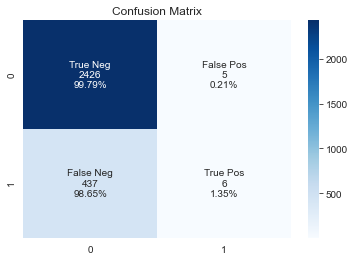

In [14]:
cnf_matrix = confusion_matrix(y_test, predictions)

# confusion matrix in percentages
cnf_percent = np.concatenate((cnf_matrix[0]/np.sum(cnf_matrix[0]), cnf_matrix[1]/np.sum(cnf_matrix[1])))

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in cnf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cnf_percent]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cnf_matrix, annot=labels, fmt='', cmap='Blues')
plt.title('Confusion Matrix')

The accuracy of the random forest model is greater at 85% than that of the single decision tree at 73%.    

The precision, recall and f1-score all increased with the random forest model for class 0 which is predicting that a loan is fully paid.    

The recall for class 1 (loan is not fully paid) decreased significantly in the random forest model. This low recall tells us that the model was not very good at predicting the number of people that did not pay off their loans.
ie. of the total # of people that did not fully pay their loans (443), this model was only able to correctly predict 11.
I would say that given the low recall, this is not a very good model for what we would like to do.     

Although most borrowers fall into the fully paid category, the importance of this model would be identifying which people do not thereby reducing your risk as a lender, which this model does not do.   

The single decision tree model has a higher recall but still less than 0.50 which isn't very good either. If I were to continue this project, my next steps would be trying to fit this to a logistic model.